## Dataloading

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from ast import literal_eval
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.rcParams.update({'font.size': 15})

### Load data

In [ ]:
df = pd.read_csv('results.csv', index_col=False)

del df['Unnamed: 0']

a = []

df['target'] = df['target'].apply(literal_eval)
joe = df['target'].values
for v in joe:
    a.append(np.array(v))
joe = np.array(a).argmax(1)
df['target'] = joe

df['mean0'] = df['mean0'].astype('float64')
df['std0'] = df['std0'].astype('float64')
df['mean1'] = df['mean1'].astype('float64')
df['std1'] = df['std1'].astype('float64')
display(df.head())

In [ ]:
def classify(x, threshold):
    mean = np.array([x['mean0'], x['mean1']])
    std = np.array([x['std0'], x['std1']])
    if (std[mean.argmax()] <= threshold):
        return mean.argmax()
    else:
        return -1

In [ ]:
df['std1'].max()

0.14538480546045815

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


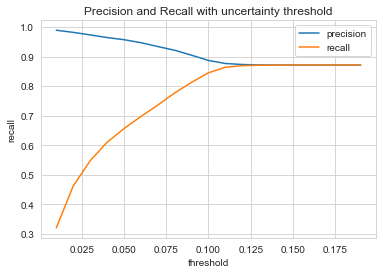

In [ ]:
from tqdm import tqdm

sns.set_style('whitegrid')

thresholds = list(np.arange(0,0.2,0.01))
precisions = []
recalls = []

for t in tqdm(thresholds):
    testdf = df
    testdf['test'] = testdf.apply(classify, args=[t], axis=1)
    certain = df[df['test']!=-1]
#     print(len(certain))
    precision = certain['target'] == certain['test']
#     print('precision',precision.mean())
    recall = df['target'] == df['test']
#     print('recall',recall.mean())
    precisions.append(precision.mean())
    recalls.append(recall.mean())

datf = pd.DataFrame({'threshold':thresholds[1:], 'precision':precisions[1:], 'recall':recalls[1:]})
sns.lineplot(data=datf, x='threshold', y='precision')
sns.lineplot(data=datf, x='threshold', y='recall')
plt.title('Precision and Recall with uncertainty threshold')
plt.legend(['precision','recall'])
# plt.set_xlabel('confidence threshold')
# plt.set_ylabel('precision/recall')

In [7]:
datf

In [8]:
i = 0

In [ ]:
print(i)
s = df.iloc[i]
print(s['text'])
if s['target'] == 0:
    colors = ['green', 'red']
else:
    colors = ['red', 'green']

x_0 = [0]
x_1 = [1]
y_0 = [s['mean0']]
y_1 = [s['mean1']]
err_0 = [s['std0']*2]
err_1 = [s['std1']*2]
print(err_0, err_1)
plt.figure(figsize=(4,8))
plt.errorbar(x_0, y_0, yerr=err_0, fmt='o', capsize=8, color=colors[0])
plt.errorbar(x_1, y_1, yerr=err_1, fmt='o', capsize=8, color=colors[1])

plt.xticks([0, 1], ['negative', 'positive'])
plt.ylim([0,1])
plt.xlim([-0.5, 1.5])
plt.xlabel('Class')
plt.ylabel('Probability')

i += 1

In [ ]:
df['y_pred'] = df.apply(classify, args=[0.075], axis=1)

for t in thresholds:
    testdf = df
    testdf['test'] = testdf.apply(classify, args=[1-t], axis=1)
    certain = df[df['test']!=-1]
    precision = certain['target'] == certain['test']
#     print('precision',precision.mean())
    recall = df['target'] == df['test']
#     print('recall',recall.mean())
    precisions.append(precision.mean())
    recalls.append(recall.mean())
    
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.title('Precision and Recall with confidence threshold')
plt.legend(['precision','recall'])
plt.set_xlabel('confidence threshold')
plt.set_ylabel('precision/recall')

In [ ]:
i = 62

In [ ]:
df['y_pred'] = df.apply(classify, args=[1], axis=1)

tdf = df[df['y_pred'] != -1]

cm = confusion_matrix(tdf['target'].values, tdf['y_pred'].values)

df_cm = pd.DataFrame(cm, index = ['negative', 'positive'],
                  columns = ['predicted negative', 'predicted positive'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='GnBu')
plt.yticks(np.arange(2)+0.5,['actual negative', 'actual positive'], va='center')
plt.title('Confusion matrix without uncertainty threshold')
plt.show()

# Mean TF-IDF per document

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from keras.datasets import imdb

In [ ]:
# reconstruct imdb reviews from the keras dataset

# credits to:
# https://gist.github.com/prinsherbert/92313f15fc814d6eed1e36ab4df1f92d 

word_to_index = imdb.get_word_index()
index_to_word = [None] * (max(word_to_index.values()) + 1)

for w, i in word_to_index.items():
    index_to_word[i] = w
    
(X_train, y_train), _ = imdb.load_data()

padding = 200

for i, review in enumerate(X_train):
    X_train[i] = review[:padding]

X_train = [
    ' '.join(
        index_to_word[i]
        for i in X_train[i]
        if i < len(index_to_word)
    ) for i in range(X_train.shape[0])
]

# X_test = [
#     ' '.join(
#         index_to_word[i]
#         for i in X_test[i]
#         if i < len(index_to_word)
#     ) for i in range(X_test.shape[0])
# ]

In [ ]:
# calculate td-idf
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X_train)

In [ ]:
# compute the mean tf-idf per document
tf_idf_avg = []
for document in X_tfidf:
    tf_idf_avg.append(document.mean())

print(tf_idf_avg[:10])

In [ ]:
# plot the tf-idf of the first n documents
n = 50
y = tf_idf_avg[:n]
x = np.arange(n)
fig, ax = plt.subplots()
ax.bar(x, y)
plt.xlabel('Document')
plt.ylabel('tf-idf')
plt.show()

In [ ]:
# cluster the documents based on their tf-idf
clusters=2
model = KMeans(n_clusters=clusters, max_iter=100)
model.fit(X_tfidf)

In [ ]:
# put the results in a pandas dataframe
results = pd.DataFrame({
    'cluster': model.labels_
})
results.head()

In [ ]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])

In [ ]:
test_1 = "i liked the characters, it was a good movie"
print("test 1:", test_1)
test_1 = vectorizer.transform([test_1])
predicted_1 = model.predict(test_1)
print("prediction", predicted_1)

test_2 = "bad, really bad, i hated it"
print("test 2:", test_2)
test_2 = vectorizer.transform([test_2])
predicted_2 = model.predict(test_2)
print("prediction", predicted_2)

# Document length

In [ ]:
x = np.arange(len(X_train))
y = []
for review in X_train:
    y.append(len(review.split()))

fig, ax = plt.subplots()
ax.bar(x, y)
plt.xlabel('document')
plt.ylabel('length')
plt.show()

In [ ]:
y = np.array(y)
print("average length:", y.mean())
print("standard deviation:", y.std())